# QHack Open Project  
## Team Qumulus Nimbus  
Team members: Praveen J and my cats. PS, I'm not a cat. 
## Project title: Feeding many trolls

### Project abstract:  
We provide a pennylane implementation of single qubit universal quantum classifier similar to that presented in [1] and [2]. We then provide an efficient method to parallely process classical data using a qram setup for the universal single qubit classifier.  
We then attempt to address quantum classifiers by data reuploading for **Quantum Data** for experiments when we have copies of the quantum state and show it's performance, which we believe has not been done before.  

We use the universal quantum classifier method and measurement strategies described in [1] to demonstrate a method of quantum music learning and generation by recasting the classifier into a markov chain like setup. We also use the qram structure we developed to combine and generate music. 

### Introduction:  


Since our goal as a qhack project is to showcase our new ideas of encoding and music processing methods, we restrict all our methods to binary classification, but with some extra short steps, all can be extended to mulitple class classification by methods similar to that outlined in [1], which we do later on for the twelve note music scale similar to the tetrehedron shown in [1].

In [17]:
import pennylane as qml
import numpy as np
import sys
import matplotlib.pyplot as plt
import time

In [75]:
#generating a circularly symmetric data set

dataset_size = 500
X_train = np.random.uniform(low=-1, high=1, size=(dataset_size, 2))
Y_train = np.ones(dataset_size)
for i in range(len(X_train)):
    dist = np.sqrt(X_train[i][0]**2 + X_train[i][1]**2)
    if dist > np.sqrt(2/np.pi):
        Y_train[i] = -1
print(Y_train[:20])
print(X_train[:20])

dataset_size = 100
X_test = np.random.uniform(low=-1, high=1, size=(dataset_size, 2))
Y_test = np.ones(dataset_size)
for i in range(len(X_test)):
    dist = np.sqrt(X_test[i][0]**2 + X_test[i][1]**2)
    if dist > np.sqrt(2/np.pi):
        Y_test[i] = -1
print(Y_test[:20])
print(X_test[:20])

[ 1.  1.  1. -1.  1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.
 -1. -1.]
[[ 0.11649354 -0.33539725]
 [-0.32230637  0.61469208]
 [-0.55493458 -0.18793142]
 [-0.21656289 -0.94961447]
 [-0.38898687  0.2459429 ]
 [-0.68698644 -0.09561394]
 [ 0.89638873  0.35828308]
 [-0.49322822  0.77498165]
 [-0.81338819  0.72070782]
 [-0.91792073  0.18353035]
 [ 0.98883796  0.4847147 ]
 [-0.66074078 -0.00832871]
 [-0.63865968 -0.96299395]
 [ 0.93153182  0.50547278]
 [ 0.295722   -0.54682013]
 [ 0.59206106 -0.97467557]
 [ 0.57636179 -0.61662235]
 [-0.74782277  0.12810187]
 [ 0.81768073 -0.12672696]
 [-0.66536034 -0.79469204]]
[ 1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1. -1. -1. -1. -1.  1.
  1. -1.]
[[ 0.24439132  0.15702763]
 [ 0.29430427 -0.02201287]
 [ 0.22592829 -0.95378055]
 [-0.23528402  0.16540201]
 [ 0.60792716  0.46589078]
 [-0.5640543   0.0718129 ]
 [ 0.24613763 -0.33938597]
 [ 0.29217823  0.56887606]
 [-0.22221762  0.44516215]
 [-0.01423294  0.17661186]
 [ 0.8753034   0.640396

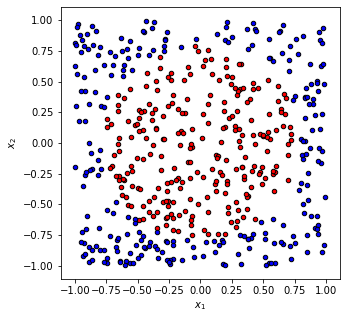

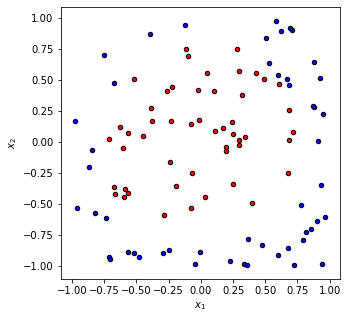

In [146]:
#plotting generated data (code from [2])
def plot_data(x, y, nclass, fig=None, ax=None): 
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
     
    # colors and labels
    col = ["red","blue"]
    lab = [1,-1]
    
    for i in range(nclass):
        ax.scatter(x[y == lab[i], 0], x[y == lab[i], 1], c=col[i], s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

plot_data(X_train, Y_train, 2)
plot_data(X_test, Y_test, 2)

In [95]:
#simple re-implementation of classical data uploading

#initializations
num_qubit = 1
num_layers = 10
weights = np.random.uniform(low=-np.pi * 2, high=np.pi * 2, size=(num_layers, 7)) #assuming 2D data input
batch_size = 5

dev = qml.device("default.qubit", wires=num_qubit)
opt = qml.GradientDescentOptimizer(stepsize=0.2)

def apply_data_layer(params, wires, data):
    qml.Rot(0, params[0, 0]*data[0] + params[0, 1], 
            params[1, 0]*data[1] + params[1, 1],  
            wires=wires)

def apply_mixing_layer(params, wires):
    qml.Rot(params[0], 
            params[1],
            params[2],
            wires=wires)

@qml.qnode(dev)
def apply_layers(params, wires, data):
    #reshaping parameters for ease
    data_params = params[:,:4].reshape((len(params), 2, 2))
    mixing_params = params[:,4:].reshape((len(params), 3))
    for i in range(num_layers):
        apply_data_layer(data_params[i], wires=wires, data=data)
        apply_mixing_layer(mixing_params[i], wires=wires)
    return qml.expval(qml.PauliZ(wires))

def square_loss(labels, predictions): #just defining it, but not using it
    loss = 0.0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def fidelity_loss(labels, predictions): #fidelity loss, unweighted
    loss = 0.0
    for l, p in zip(labels, predictions):
        loss = loss + (1 - (1 + l*p)/2)
    loss = loss / len(labels)
    return loss

def cost(w, X, Y):
    predictions = [apply_layers(w, wires=0, data = x) for x in X]
    return fidelity_loss(Y, predictions)

n = int(len(X_train)/batch_size)
weight = weights
for a in range(n):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_train_batch = []
    Y_train_batch = []
    for i in batch_index:
        X_train_batch.append(X_train[i])
        Y_train_batch.append(Y_train[i])
    weight = opt.step(lambda w: cost(w, X_train_batch, Y_train_batch), weight)
    #print('Cost at step '+ str(a) + ': ' + str(cost(we, X_train_batch, Y_train_batch)))
we = we

In [99]:
#simple re-implementation of classical data uploading, without mixing layer as seen in [2]

#initializations
num_qubit = 1
num_layers = 10
weights = np.random.uniform(low=-np.pi * 2, high=np.pi * 2, size=(num_layers, 2)) #assuming 2D data input
batch_size = 5

dev = qml.device("default.qubit", wires=num_qubit)
opt = qml.GradientDescentOptimizer(stepsize=0.2)

def apply_data_layer(params, wires, data):
    qml.Rot(0, data[0] + params[0], 
            data[1] + params[1], 
            wires=wires)

def apply_mixing_layer(params, wires):
    qml.Rot(params[0], 
            params[1],
            params[2],
            wires=wires)

@qml.qnode(dev)
def apply_layers(params, wires, data):
    #reshaping parameters for ease
    data_params = params[:,:2].reshape((len(params), 2))
    #mixing_params = params[:,4:].reshape((len(params), 3))
    for i in range(num_layers):
        apply_data_layer(data_params[i], wires=wires, data=data)
        #apply_mixing_layer(mixing_params[i], wires=wires)
    return qml.expval(qml.PauliZ(wires))

def square_loss(labels, predictions): #just defining it, but not using it
    loss = 0.0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def fidelity_loss(labels, predictions): #fidelity loss, unweighted
    loss = 0.0
    for l, p in zip(labels, predictions):
        loss = loss + (1 - (1 + l*p)/2)
    loss = loss / len(labels)
    return loss

def cost(w, X, Y):
    predictions = [apply_layers(w, wires=0, data = x) for x in X]
    return fidelity_loss(Y, predictions)

n = int(len(X_train)/batch_size)
weight = weights
for a in range(n):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_train_batch = []
    Y_train_batch = []
    for i in batch_index:
        X_train_batch.append(X_train[i])
        Y_train_batch.append(Y_train[i])
    weight = opt.step(lambda w: cost(w, X_train_batch, Y_train_batch), weight)
we3 = we

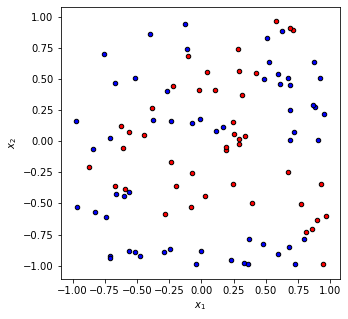

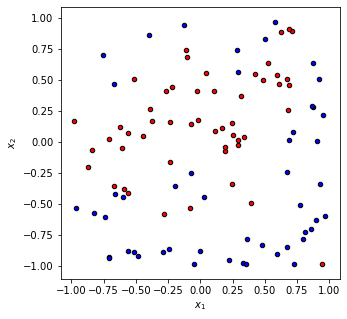

In [96]:
#testing and plotting trained model
def plot_data_model(weights, test, wires):
    tests = [apply_layers(weights, wires=wires, data=x) for x in test]
    pred = np.ones(len(tests))
    for a in range(len(tests)):
        if tests[a] > 0:
            pred[a] = 1
        else:
            pred[a] = -1
    plot_data(X_test, pred, 2)

plot_data_model(we, X_test, wires=0) # unsqared fidelity loss function
plot_data_model(we2, X_test, wires=0) # squared fidelity loss function

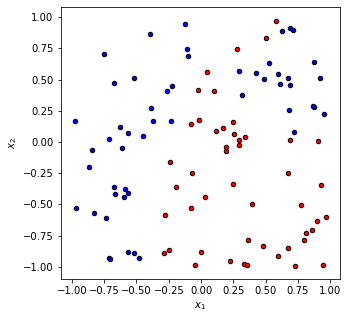

In [100]:
plot_data_model(we3, X_test, wires=0)

In the above plots,
- Plot 1 is unsquared fidelity loss function  
- Plot 2 is squared fidelity loss function  
- Plot 3 is unsquared fidelity loss function, but with no mixing layers as given in [2]  

We infer that not squaring of the loss function before averaging does not affect the model too much, which could be because fidelity itself is geometric and $1-f$ is a measure of the distance to the point. With this, we then proceed to qram the classifier, which is mathematically possible only because of the unsquared fidelity loss function.

### Data classification and re-uploading with a qram  
We use a simple amplitude encoding as described in [3] to encode 2 dimensional input data. We restrict ourselves to binary classification for simplicity.  

<img src="images/qram.png">

In each encoding step, we use controlled gates, controlled on the qram qubits. This allows us to parallely compute multiple training cases, while trading off circuit depth. Note that we cannot use a standard qram setup since we are dealing with a continuous domain of values of input whereas for a standard qram setup we have classical bit sequences.  

Since we are using circuit fidelity as given in the equation above, we do something smart, we apply controlled gates again based on the targetted training classification \[0, 1\] and then we measure the output expectation value (perform a state tomography for fidelity). We apply a NOT gate if the label is -1 ($|1\rangle\langle1|$). On measuring expectation over Pauli Z basis, we get:
State post circuit:

\begin{align*}
    |\psi\rangle &= \frac{1}{\sqrt{N}} \sum_i |i\rangle|\psi_i\rangle \text{ where } \psi_i \text{ refers to state post circuit} \\
    x &= \frac{1}{N}(\sum_i \langle \psi_i | (|0\rangle\langle 0| - |1\rangle\langle 1|)|\psi_i \rangle)\\
    \text{Required fidelity } f &= \frac{1}{N}(\sum_i \langle \psi_i | (|0\rangle\langle 0|)|\psi_i \rangle)\\
    &= \frac{1}{2N}(\sum_i \langle \psi_i |(|0\rangle\langle 0| + |1\rangle\langle 1| + |0\rangle\langle 0| - |1\rangle\langle 1|)|\psi_i \rangle)\\
    &= \frac{1}{2}(1 + x)\\
    \text{Cost function: } L &= 1 - f = \frac{1}{2}(1 - x) \text{ where x is the measured value.}
\end{align*}

Note that here for the cost function, we don't square the difference as $1-x$ will be positive always and also in the previous section, we've showed that this cost function works alright eventhough it's linear.

For a n qubit qram, we can process a batch size of $2^n$. Additionally we can proces batches of size $m \neq 2^k$ by not performing gate operations on those states and appropriately modifying fidelity in the end. For a batch size of m, qrammed over n qubits, $N = 2^n > m$:
$$\text{Cost function: } L = \frac{1}{2}(1-x)\times \frac{N}{m}$$  

Since we see that it is only a multiplicative factor, we don't need to bother about it while optimizing, but to maintain efficiency of the optimising step and the chosen step size, we ought to factor this in.

Additionally to optimise the circuit, we perform some preprocessing on the rotation angles to reduce some mulitple qubit controlled rotation gates into uncontrolled and lower order control rotation gates. For example, for a qram over states (batch size 4), if $a, b, c, d$ were the rotation angles for each of them, we have the following decomposition:

<img src="images/simplification.png">

Now let's implement this for a batch size of 4 (2 qubit qram). Note that for ease of implementation and reducing depth, we have introduced a 4th qubit to act as an indicator for $|11\rangle$ qram state so as to avoid repeated Toffoli gates at every layer and step.

In [107]:
#initialization
num_qubit = 4
layers = 10
#X_train = [[0.5, 0.3, -0.4], [0.4, 0.2, 0.1], [0.4, 0.2, 0.2], [-0.5, 0.3, 0.6]]
#Y_train = [-1, 1, 1, -1]
batch_size = 4 #qrammed!
weights = np.random.uniform(low=-np.pi * 2, high=np.pi * 2, size=(num_layers, 7)) #2D input

dev2 = qml.device("default.qubit", wires=num_qubit)
opt = qml.GradientDescentOptimizer(stepsize=0.2)

def apply_data_layer_qram(params, wires, data):
    a = []
    b = []
    #c = []
    for i in range(len(data)):
        a.append(params[0, 0]*data[i][0] + params[0, 1])
        b.append(params[1, 0]*data[i][1] + params[1, 1])
        #c.append(params[2, 0]*data[i][2] + params[2, 1])
    transform = lambda arr: [arr[0], arr[1] - arr[0], arr[2] - arr[0], arr[3] + arr[0] - arr[1] - arr[2]]
    a = transform(a)
    b = transform(b)
    #c = transform(c)
    
    qml.RY(a[0], wires=wires[0])
    qml.CRY(a[1], wires=[wires[1], wires[0]])
    qml.CRY(a[2], wires=[wires[2], wires[0]])
    qml.CRY(a[3], wires=[wires[3], wires[0]])
    
    qml.RZ(b[0], wires=wires[0])
    qml.CRZ(b[1], wires=[wires[1], wires[0]])
    qml.CRZ(b[2], wires=[wires[2], wires[0]])
    qml.CRZ(b[3], wires=[wires[3], wires[0]])
    
    #qml.RZ(c[0], wires=wires[0])
    #qml.CRZ(c[1], wires=[wires[1], wires[0]])
    #qml.CRZ(c[2], wires=[wires[2], wires[0]])
    #qml.CRZ(c[3], wires=[wires[3], wires[0]])

def apply_mixing_layer(params, wires):
    qml.Rot(params[0], 
            params[1],
            params[2],
            wires=wires)

@qml.qnode(dev2)
def apply_layers_qram_train(params, wires, data, label):
    #qram initialization on wires 1, 2; wire 3 is used as an auxilary
    qml.Hadamard(wires=wires[1])
    qml.Hadamard(wires=wires[2])
    qml.Toffoli(wires=wires[1:])
    
    #reshaping parameters for ease
    data_params = params[:,:4].reshape((len(params), 2, 2))
    mixing_params = params[:,4:].reshape((len(params), 3))
    
    for i in range(num_layers):
        apply_data_layer_qram(data_params[i], wires=wires, data=data)
        apply_mixing_layer(mixing_params[i], wires=wires[0])
    
    #label encoding for batch fidelity
    if label[1] == -1:
        qml.CNOT(wires=[wires[1], wires[0]])
    if label[2] == -1:
        qml.CNOT(wires=[wires[2], wires[0]])
    if label[3] == -1:
        qml.CNOT(wires=[wires[3], wires[0]])
    if label[0] == -1:
        qml.PauliX(wires=wires[1])
        qml.PauliX(wires=wires[2])
        qml.Toffoli(wires=[wires[1], wires[2], wires[0]])
    return qml.expval(qml.PauliZ(wires[0]))

def cost_qram(w, X, Y):
    x = apply_layers_qram_train(w, wires=[0, 1, 2, 3], data = X, label = Y)
    return (1-x)/2

n = int(len(X_train)/batch_size)

for a in range(n):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_train_batch = []
    Y_train_batch = []
    for i in batch_index:
        X_train_batch.append(X_train[i])
        Y_train_batch.append(Y_train[i])
    weights = opt.step(lambda w: cost_qram(w, X_train_batch, Y_train_batch), weights)
    x = cost_qram(weights, X_train_batch, Y_train_batch)
    #print('Cost at step '+ str(a) + ': ' + str(x))

we4 = weights

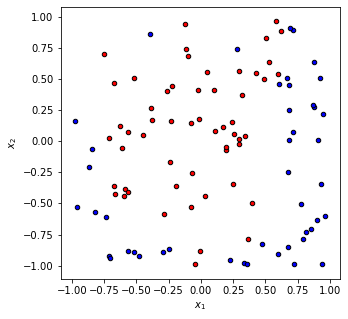

In [108]:
#plotting qram trained model

def apply_data_layer(params, wires, data):
    qml.Rot(0, params[0, 0]*data[0] + params[0, 1], 
            params[1, 0]*data[1] + params[1, 1],  
            wires=wires)

def apply_mixing_layer(params, wires):
    qml.Rot(params[0], 
            params[1],
            params[2],
            wires=wires)

@qml.qnode(dev)
def apply_layers(params, wires, data):
    #reshaping parameters for ease
    data_params = params[:,:4].reshape((len(params), 2, 2))
    mixing_params = params[:,4:].reshape((len(params), 3))
    for i in range(num_layers):
        apply_data_layer(data_params[i], wires=wires, data=data)
        apply_mixing_layer(mixing_params[i], wires=wires)
    return qml.expval(qml.PauliZ(wires))

def plot_data_model(weights, test, wires):
    tests = [apply_layers(weights, wires=wires, data=x) for x in test]
    pred = np.ones(len(tests))
    for a in range(len(tests)):
        if tests[a] > 0:
            pred[a] = 1
        else:
            pred[a] = -1
    plot_data(X_test, pred, 2)

plot_data_model(we4, X_test, wires=0)

We can see that, for a simulator, the time of evaluation for the qrammed case is sometimes slower as compared to when each data point of the batch is individually evaluated. This would only get better as the number of qubits increase with an increase in batch size. Before proceding, lets do a short sanity check:  
- For a n qubit qram, batch size is $2^n = N$.  
    - Ancilla qubits required for multi-qubit control gates $ = n-2$.  
    - Total qubits: $n + n-2 + 1 = 2n - 1$ (QRAM + ancilla + classifier).  
    - Increase in circuit depth (due to qram) $\rightarrow$ Increase in circuit depth of data layer (mixing layer remains the same and constant), thus by a factor of $\approx N = 2^n$  
    - Number of measurements performed: 1 observable for $2^n$ test cases.
- If we had instead just used single qubit classifier parallely on the $2n-1$ qubits available:
    - Time of evaluation: $O(\frac{2^n}{2n-1}) \approx O(2^{n-\log n - 1})$  
    - Number of measurements performed: $2^n$ observables, $O(\frac{2^n}{2n-1}) \approx O(2^{n-\log n - 1})$ number of experiments.  
Effectively, the number of measurements/shots required would drastically reduce, while trading off depth, which for resonable number of layers does not cause too much errors.

Lets now evaluate this on a real device and see how it performs.

### Quantum data re-uploading (?)  
We next proceed to try to tackle one of the open problems mentioned in [1].

Due to no cloning, we cannot directly replicate quantum data and a naive attempt at data re-uploading boils down to something similar to normal quantum machine learning, albiet with quantum data, or also where classical input data amplitude encoded as any attempts to perform control gates controlled on the quantum data qubits are just similar entangling gates and the presence of input data in the quantum classifier is not  amplified, it's the same amount of information encoded. See figure below.  

If the experiment to produce the input is reproducable, we propose a new method to learn quantum data and we test it out to see if we actually do better than a single input copy with an equivalent number of layers. For doing this efficiently, we use the circular network connectivity of Rigetti Aspen-9 and design the circuit accordingly by combining swaps and the CNOTs that entangle.  

To generate quantum data, we use 2D classical data and treat a function of them as $\theta$ and $\phi$ of a qubit. Single controlled Z or controlled NOT gates are sufficient since any parameterized control gates or rotations can be reduced to CNOTs and parameterised single qubit rotations, which can be combined with the mixing layer.  

<img src="images/qreupload.png">

[[ 0.03488199 -2.76806926 -2.4074217 ]
 [-2.87080343 -3.59053593  3.44042901]
 [-4.64771065  4.74229538 -2.52193861]
 [-0.50413057 -4.86733695 -6.36987514]
 [ 2.40866515 -1.46942438  4.92096696]
 [ 1.39348207  3.80083719 -0.38107923]
 [ 4.55353313  5.20512066 -3.27530974]
 [-2.83208711 -4.45995969  5.81924849]
 [-4.91059669  2.13103889 -3.76307165]
 [ 1.66249085  4.40628285 -0.83187931]
 [-0.58965288 -5.38314303 -3.20142077]]
[[ 0.24439132  0.15702763]
 [ 0.29430427 -0.02201287]
 [ 0.22592829 -0.95378055]
 [-0.23528402  0.16540201]
 [ 0.60792716  0.46589078]
 [-0.5640543   0.0718129 ]
 [ 0.24613763 -0.33938597]
 [ 0.29217823  0.56887606]
 [-0.22221762  0.44516215]
 [-0.01423294  0.17661186]]
[tensor(0.71945572, requires_grad=True), tensor(0.60216666, requires_grad=True), tensor(0.75850874, requires_grad=True), tensor(0.7390303, requires_grad=True), tensor(-0.33260375, requires_grad=True), tensor(-0.19987712, requires_grad=True), tensor(0.71563454, requires_grad=True), tensor(0.60748562

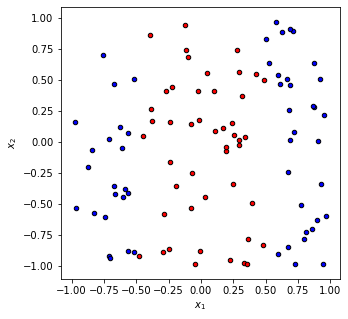

In [142]:
# quantum data re-uploading testing - Control case, single copy only
num_qubit = 2
num_layers = 11
weights = np.random.uniform(low=-np.pi * 2, high=np.pi * 2, size=(num_layers, 3)) #only for mixing layer
dev3 = qml.device("default.qubit", wires=num_qubit)
opt = qml.GradientDescentOptimizer(stepsize=0.2)
batch_size = 5

def apply_mixing_layer(params, wires):
    qml.Rot(params[0], 
            params[1],
            params[2],
            wires=wires)

@qml.qnode(dev3)
def apply_layers(params, wires, data):
    #initializing first qubit
    qml.RY(data[0]*np.pi, wires=wires[0])
    qml.RZ(data[1]*np.pi, wires=wires[0])
    
    #adding layers
    for i in range(num_layers):
        qml.CZ(wires=wires)
        apply_mixing_layer(params[i], wires=wires[1])
    return qml.expval(qml.PauliZ(wires[1]))

def fidelity_loss(labels, predictions): #fidelity loss, unweighted
    loss = 0.0
    for l, p in zip(labels, predictions):
        loss = loss + (1 - (1 + l*p)/2)
    loss = loss / len(labels)
    return loss

def cost(w, X, Y):
    predictions = [apply_layers(w, wires=[0, 1], data = x) for x in X]
    return fidelity_loss(Y, predictions)

n = int(len(X_train)/batch_size)
weight = weights
for a in range(n):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_train_batch = []
    Y_train_batch = []
    for i in batch_index:
        X_train_batch.append(X_train[i])
        Y_train_batch.append(Y_train[i])
    weight = opt.step(lambda w: cost(w, X_train_batch, Y_train_batch), weight)
we5 = weight

print(we5)
def plot_data_model(weights, test, wires):
    print(test[:10])
    tests = [apply_layers(weights, wires=wires, data=x) for x in test]
    print(tests[:10])
    pred = np.ones(len(tests))
    for a in range(len(tests)):
        if tests[a] > 0:
            pred[a] = 1
        else:
            pred[a] = -1
    plot_data(X_test, pred, 2)

plot_data_model(we5, X_test, wires=[0, 1])

[[ 0.24439132  0.15702763]
 [ 0.29430427 -0.02201287]
 [ 0.22592829 -0.95378055]
 [-0.23528402  0.16540201]
 [ 0.60792716  0.46589078]
 [-0.5640543   0.0718129 ]
 [ 0.24613763 -0.33938597]
 [ 0.29217823  0.56887606]
 [-0.22221762  0.44516215]
 [-0.01423294  0.17661186]]
[tensor(0.03292695, requires_grad=True), tensor(0.02773021, requires_grad=True), tensor(0.12722688, requires_grad=True), tensor(0.0351935, requires_grad=True), tensor(1.12182486e-12, requires_grad=True), tensor(-9.84438157e-06, requires_grad=True), tensor(0.00034275, requires_grad=True), tensor(2.10313439e-07, requires_grad=True), tensor(3.25364731e-08, requires_grad=True), tensor(0.24384983, requires_grad=True)]


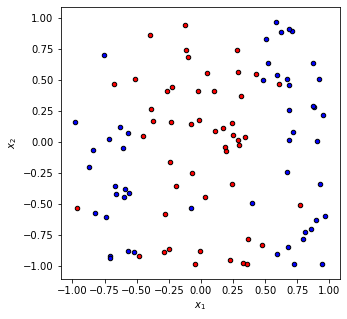

In [155]:
# quantum data re-uploading testing - Our method, efficiently done as seen in the image below:
num_layers = 15
num_qubits = 1 + num_layers
weights = np.random.uniform(low=-np.pi * 2, high=np.pi * 2, size=(num_layers, 3)) #only for mixing layer
dev4 = qml.device("default.qubit", wires=num_qubits)
opt = qml.GradientDescentOptimizer(stepsize=0.2)
batch_size = 5

def apply_mixing_layer(params, wires):
    qml.Rot(params[0], 
            params[1],
            params[2],
            wires=wires)

@qml.qnode(dev4)
def apply_layers(params, wires, data):
    #adding layers
    for i in range(num_layers):
        if i % 2:
            qml.RY(data[0]*np.pi, wires=wires[i+1])
            qml.RZ(data[1]*np.pi, wires=wires[i+1])
        else:
            qml.RY(data[1]*np.pi, wires=wires[i+1])
            qml.RZ(data[0]*np.pi, wires=wires[i+1])
        qml.CNOT(wires=[wires[i], wires[i+1]])
        qml.CNOT(wires=[wires[i+1], wires[i]])
        apply_mixing_layer(params[i], wires=wires[-1])
    return qml.expval(qml.PauliZ(wires[-1]))

def fidelity_loss(labels, predictions): #fidelity loss, unweighted
    loss = 0.0
    for l, p in zip(labels, predictions):
        loss = loss + (1 - (1 + l*p)/2)
    loss = loss / len(labels)
    return loss

def cost(w, X, Y):
    predictions = [apply_layers(w, wires=list(range(num_qubits)), data = x) for x in X]
    return fidelity_loss(Y, predictions)

n = int(len(X_train)/batch_size)
weight = weights
for a in range(n):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_train_batch = []
    Y_train_batch = []
    for i in batch_index:
        X_train_batch.append(X_train[i])
        Y_train_batch.append(Y_train[i])
    weight = opt.step(lambda w: cost(w, X_train_batch, Y_train_batch), weight)
we6 = weight

def plot_data_model(weights, test, wires):
    print(test[:10])
    tests = [apply_layers(weights, wires=wires, data=x) for x in test]
    print(tests[:10])
    pred = np.ones(len(tests))
    for a in range(len(tests)):
        if tests[a] > 0:
            pred[a] = 1
        else:
            pred[a] = -1
    plot_data(X_test, pred, 2)

plot_data_model(we6, X_test, wires=list(range(num_qubits)))

In the above case, we noticed that the data point $x_2$ does not get expressed, (ie) the phase does not get expressed or influence the classification. Following this, we tried inserting many gates like rotations and hadamards between the input and the control gates but the result did not improve. But it did improve a lot when we did the following: Consider the hypothetical case that we get quantum data or able to transform $\cos\theta |0> + e^{i\phi}\sin\theta|1>$ to $\cos\phi|0> + e^{i\theta}\sin\phi|1>$, using this, in alternate layers we exchange the data[0] and data[1] while creating the input. This gives a considerably better result as seen below. But is such a unitary transform possible independent of input data? See the figure below:

We see that such a transform is data dependent (possible only when $\theta$ is equal to $\phi$). Thus we can't do such a rotation. We leave this to future work beyond this point.

### Music generation using Quantum universal classifier  
In this section, we propose two new methods of quantum music learning and generation. First, we use the classification method for multiclass classification method as seen in [1]. Here we use a cubic structure mapping for 7 note scale + rest, another new 12 note full scale for all notes given by a icosahedron, and a pentatonic scale using a regular dodecahedron structure.  
Additionally [1] does give an alternate method of class geometry of divisions along a single great circle of the sphere. We don't use it here.

<img src="images/something.png">

#### Why is this probably a good music generating model? A sanity check  
You are probably wondering, like us when we first thought of it about why this circuit is probably a good fit into this. We guess the following reasons are valid to state:
- The fact that it uses a single qubit, gives a geometrically symmetric structure of a sphere which makes labelling and embedding notes easy and intuitive.
- Given the cost function is based on fidelity, which is analogus to a distance measure (but note that fidelity is not mathematically a metric), this allows to easily define proximity based note ordering and learning.
- The last layer, $(i-1)^{\hbox{th}}$ has much more influence on the $i^{th}$ note and each preceeding note influences the next note by by lesser and lesser in a non-linear fashion since the rotations are on a sphere, thus factoring in time sequencing of notes. 

#### Encoding music notes
We encode music notes as 2D angular data (or the angle of RY and RZ rotation required to obtain that point) corresponding to their position on the mapping shown earlier.  
At each encoding layer, we either:  
- Input the absolute angular data of the notes as the input data
- Input the angular differences between conscecutive notes

To find fidelities with various points, we use a method similar to that we used in one of the 
Effectively both methods should boil down to the same with some extra non-linearity due to the commutation with the mixing layers. We try both methods here.

In [195]:
#method 1, encoding absolute data, no qrams

num_layers = 4
num_qubit = 1
weights = np.random.uniform(low=-np.pi * 2, high=np.pi * 2, size=(num_layers, 7)) #assuming 2D data input
batch_size = 1
notes = 8 # scale + rest
m_train = [2, 1, 0, 1, 2, 2, 2, 1, 1, 1, 2, 4, 4, 2, 1, 0, 1, 2, 2, 2, 2, 1, 1, 2, 1] #mary had a little lamb xD

#angles and stuff for cubic setup
a = 2*np.arcsin(1/np.sqrt(3))
b = np.pi - a
c = np.pi/3
d = np.cos(a/2)**2
e = np.cos(b/2)**2
target_angles = [[0, 0], [a, 0], [a, 2*c], [a, 4*c], [b, c], [b, 3*c], [b, 5*c], [0, np.pi]] #note database, list of angle pairs, y rot followed by z rots
fidelity_list_map = [[1, d, d, d, e, e, e, 0], 
                     [d, 1, e, e, d, 0, d, e],
                     [d, e, 1, e, d, d, 0, e],
                     [d, e, e, 1, 0, d, d, e],
                     [e, d, d, 0, 1, e, e, d],
                     [e, 0, d, d, e, 1, e, d],
                     [e, d, 0, d, e, e, 1, d],
                     [0, e, e, e, d, d, d, 1]]
mapping = {0:'C',
           1:'D',
           2:'E',
           3:'F',
           4:'G',
           5:'A',
           6:'B',
           7:''}

dev = qml.device("default.qubit", wires=num_qubit)
opt = qml.GradientDescentOptimizer(stepsize=0.2)

def apply_data_layer(params, wires, data):
    qml.Rot(0, params[0, 0]*data[0] + params[0, 1], 
            params[1, 0]*data[1] + params[1, 1],  
            wires=wires)

def apply_mixing_layer(params, wires):
    qml.Rot(params[0], 
            params[1],
            params[2],
            wires=wires)

@qml.qnode(dev)
def apply_layers(params, wires, data, target):
    #reshaping parameters for ease
    data_params = params[:,:4].reshape((len(params), 2, 2))
    mixing_params = params[:,4:].reshape((len(params), 3))
    for i in range(num_layers):
        angles = target_angles[data[i]]
        apply_data_layer(data_params[i], wires=wires, data=angles)
        apply_mixing_layer(mixing_params[i], wires=wires)
    
    #for fidelity with target state:
    angles = target_angles[target] #fetching angles of the note
    qml.RZ(-angles[1], wires=wires)
    qml.RY(-angles[0], wires=wires)
    return qml.expval(qml.PauliZ(wires))

def fidelity(x):
    return (1+x)/2

#array of fidelities with different note states
def fidelities(params, wires, data):
    fid = []
    for i in range(notes):
        x = apply_layers(params, wires=wires, data=data, target=i)
        fid.append(fidelity(x))
    return fid

def fidelity_loss(labels, fid_list): #fidelity loss, unweighted but for multiple clases
    loss = 0.0
    for l, fids in zip(labels, fid_list):
        target_fid_list = fidelity_list_map[l]
        for a in range(notes):
            loss = loss + (target_fid_list[a] - fids[a])**2
    loss = loss / len(labels)
    loss = loss / notes
    return loss

def cost(w, X, Y):    
    fidelity_lists = [fidelities(w, wires=0, data = x) for x in X]
    return fidelity_loss(Y, fidelity_lists)

n = int(len(m_train[num_layers:]))
weight = weights

for a in range(n):
    seq = [m_train[a:a + num_layers]]
    weight = opt.step(lambda w: cost(w, seq, [m_train[a+num_layers]]), weight)

print('Model trained successfully')    

Model trained successfully


In [196]:
#predicting music based on trained model parameters - weight
sample = m_train[-num_layers:]
l = 60
for a in range(l):
    f = fidelities(weight, wires=0, data=sample[-num_layers:])
    sample.append(f.index(max(f)))
print(sample)

[1, 1, 2, 1, 0, 6, 0, 6, 6, 6, 6, 1, 4, 3, 1, 5, 5, 0, 0, 1, 1, 6, 5, 0, 3, 5, 3, 2, 6, 6, 5, 5, 4, 4, 7, 5, 6, 6, 3, 4, 6, 6, 6, 3, 5, 6, 2, 6, 5, 5, 5, 4, 5, 0, 4, 3, 4, 4, 5, 3, 6, 6, 5, 6]


In [197]:
#writing music (code snippets from https://towardsdatascience.com/mathematics-of-music-in-python-b7d838c84f72)
from scipy.io.wavfile import write
import IPython

samplerate = 44100 #Frequecy in Hz

def get_wave(freq, duration=0.5):
    amplitude = 4096
    t = np.linspace(0, duration, int(samplerate * duration))
    wave = amplitude * np.sin(2 * np.pi * freq * t)
    return wave

def get_piano_notes():
    # White keys are in Uppercase and black keys (sharps) are in lowercase
    octave = ['C', 'c', 'D', 'd', 'E', 'F', 'f', 'G', 'g', 'A', 'a', 'B'] 
    base_freq = 261.63 #Frequency of Note C4
    note_freqs = {octave[i]: base_freq * pow(2,(i/12)) for i in range(len(octave))}        
    note_freqs[''] = 0.0 # silent note
    return note_freqs

def get_song_data(music_notes, tempo):
    note_freqs = get_piano_notes() # Function that we made earlier
    song = [get_wave(note_freqs[note], 60/tempo) for note in music_notes.split('-')]
    song = np.concatenate(song)
    return song

def numbers_to_notes(num_list, mapping):
    notes = ''
    for a in num_list[1:]:
        notes =  notes + '-' +str(mapping[a])
    return notes[1:]

def notes_to_numbers(notes, mapping):
    num_list = [mapping[note] for note in notes.split('-')]
    return num_list
    
note_freqs = get_piano_notes()


music_notes = numbers_to_notes(sample[12:], mapping)
data = get_song_data(music_notes, 180)

data = data * (16300/np.max(data)) # Adjusting the Amplitude (Optional)


write('music/mary_had_no_lambs_8_2.mp3', samplerate, data.astype(np.int16))


IPython.display.Audio('music/mary_had_no_lambs_8_2.mp3')

### Future work and ideas  
The music generating model presented here is new, to our knowledge and needs more exploration in terms of effects of geometric structure/ordering and other encoding methods.  

### Acknowledgements  
I'd like to thank the QHack team and Xanadu for the event and this opportunity to explore and listen to amazing talks by amazing folks.  
I'd like to thank Hari P Narayanan, my friend for our fruitful discussions on music and optimal note maps to use; and Rahul Shah for the drawing tools to help make my project visually attractive and easy to understand.  
I'd like to thank the folks at the Uncertain systems (Quantum Intuition's) Discord server for being a constant support and a peer group to discuss random quantum stuff.  
I'd also like to to thank qiskit and for the qiskit challenge for happening which introduced me to the idea of qram.  
Finally, I'd like to thank Amazon and Amazon Braket team for the help and for (probably) sponsoring this event.

All images were made by me, and code were written by me, unless mentioned explicitly.

## References  
[1] - https://quantum-journal.org/papers/q-2020-02-06-226/  
[2] - https://github.com/AlbaCL/qhack21f  
[3] - https://journals.aps.org/pra/abstract/10.1103/PhysRevA.102.032420